In [1]:
import numpy as np
import uproot
import awkward
import matplotlib.pyplot as plt
import matplotlib.colors as col
from scipy.optimize import curve_fit
import ROOT as r

Welcome to JupyROOT 6.10/08


In [2]:
treename = "trajmcsntuple/tree"

f_mc_sce = uproot.open("mcs_bnb_nu_corsika_SCE_50k.root")
t_mc_sce = f_mc_sce[treename]

f_mc_nosce = uproot.open("mcs_bnb_nu_corsika_noSCE_50k.root")
t_mc_nosce = f_mc_nosce[treename]

f_data_rol = uproot.open("mcs_bnb_optfilter_C1_5e19_100k.root")
t_data_rol = f_data_rol[treename]

f_mc_only = uproot.open("/Users/cerati/Notebooks/mcc9.0-files/allstudies_prodgenie_bnb_nu_only_mcc9_v12_reco2.root")
t_mc_only = f_mc_only[treename]

f_data_run1 = uproot.open("/Users/cerati/Notebooks/mcc9.0-files/allstudies_data_bnb_optfilter_C1_5e19_goodruns_v08_00_00_12_reco2.root")
t_data_run1 = f_data_run1[treename]

f_ovrl_run1 = uproot.open("/Users/cerati/Notebooks/mcc9.0-files/allstudies_prodgenie_bnb_nu_uboone_overlay_mcc9_v12.root")
t_ovrl_run1 = f_ovrl_run1[treename]

#t_data_run1.show()

In [3]:
def makeBiasAndResolPlots(selection,trkMom_MuFwd,trkMom_RangeMu,xmin,xmax,xstp,label,color):
    bins = np.arange(xmin,xmax+xstp,xstp)
    loedges = bins[:-1]
    hiedges = bins[1:]
    #print loedges
    #print hiedges
    hlist = []
    hb = r.TH1F("bias"+label,"",len(loedges),xmin,xmax)
    hr = r.TH1F("resol"+label,"",len(loedges),xmin,xmax)
    hb.GetXaxis().SetTitle("p_{range} [GeV]")
    hr.GetXaxis().SetTitle("p_{range} [GeV]")
    hb.GetYaxis().SetTitle("p_{mcs}^{-1} fractional bias")
    hr.GetYaxis().SetTitle("p_{mcs}^{-1} fractional resolution")
    hb.GetYaxis().SetTitleOffset(1.6)
    hr.GetYaxis().SetTitleOffset(1.6)
    hr.SetLineColor(color)
    hb.SetLineColor(color)
    hr.SetLineColor(color)
    for b in range(0,len(loedges)):
        #print b, loedges[b], hiedges[b]
        abin = selection&(trkMom_RangeMu>=loedges[b])&(trkMom_RangeMu<hiedges[b])
        mcscontb = trkMom_MuFwd[abin]
        rngcontb = trkMom_RangeMu[abin]
        vals = (1./mcscontb - 1./rngcontb)/(1./rngcontb)
        h = r.TH1F(label+"bin"+str(b),label+"bin"+str(b),20,-0.6,0.6)
        for v in vals: h.Fill(v)
        #c = r.TCanvas("c")
        #c.Draw()
        #h.Draw()
        fr = h.Fit("gaus","MESQ","",-0.2,0.2)
        hlist.append(h)
        if int(fr)>0:
            #print fr.GetParams()[0], fr.GetErrors()[0]
            #print fr.GetParams()[1], fr.GetErrors()[1]
            #print fr.GetParams()[2], fr.GetErrors()[2]
            hb.SetBinContent(b+1,fr.GetParams()[1])
            hb.SetBinError(b+1,fr.GetErrors()[1])
            hr.SetBinContent(b+1,fr.GetParams()[2])
            hr.SetBinError(b+1,fr.GetErrors()[2])
    return hb, hr, hlist

In [9]:
version = 1

In [10]:
opt = ""
tag = "Contained Tracks"
if version==1:
    opt = "_rm10"
    tag = "Pseudo-exiting Tracks (rm 10cm)"
if version==2:
    opt = "_rm50"
    tag = "Pseudo-exiting Tracks (rm 50cm)"
if version==3:
    opt = "_rm80"
    tag = "Pseudo-exiting Tracks (rm 80cm)"

label_mc = "MC BNB only"
trkLength_mc = t_mc_only.array("trkLength"+opt)
trkMom_MuFwd_mc = t_mc_only.array("trkMom_MuFwd"+opt)
trkMomErr_MuFwd_mc = t_mc_only.array("trkMomErr_MuFwd"+opt)
trkMom_RangeMu_mc = t_mc_only.array("trkMom_RangeMu")
trkIsContained_mc = t_mc_only.array("trkIsContained")

label_data = "Data Run1 5E19"
trkLength_data = t_data_run1.array("trkLength"+opt)
trkMom_MuFwd_data = t_data_run1.array("trkMom_MuFwd"+opt)
trkMomErr_MuFwd_data = t_data_run1.array("trkMomErr_MuFwd"+opt)
trkMom_RangeMu_data = t_data_run1.array("trkMom_RangeMu")
trkIsContained_data = t_data_run1.array("trkIsContained")

label_ovrl = "BNB Overlay Run1"
trkLength_ovrl = t_ovrl_run1.array("trkLength"+opt)
trkMom_MuFwd_ovrl = t_ovrl_run1.array("trkMom_MuFwd"+opt)
trkMomErr_MuFwd_ovrl = t_ovrl_run1.array("trkMomErr_MuFwd"+opt)
trkMom_RangeMu_ovrl = t_ovrl_run1.array("trkMom_RangeMu")
trkIsContained_ovrl = t_ovrl_run1.array("trkIsContained")

In [11]:
selection_mc = (trkIsContained_mc==1)&(trkLength_mc>100)&(trkMomErr_MuFwd_mc<7.5)&((trkMom_MuFwd_mc-trkMom_RangeMu_mc)>-0.2)
mcscont_mc = trkMom_MuFwd_mc[selection_mc]
rngcont_mc = trkMom_RangeMu_mc[selection_mc]

selection_data = (trkIsContained_data==1)&(trkLength_data>100)&(trkMomErr_MuFwd_data<7.5)&((trkMom_MuFwd_data-trkMom_RangeMu_data)>-0.2)
mcscont_data = trkMom_MuFwd_data[selection_data]
rngcont_data = trkMom_RangeMu_data[selection_data]

selection_ovrl = (trkIsContained_ovrl==1)&(trkLength_ovrl>100)&(trkMomErr_MuFwd_ovrl<7.5)&((trkMom_MuFwd_ovrl-trkMom_RangeMu_ovrl)>-0.2)
mcscont_ovrl = trkMom_MuFwd_ovrl[selection_ovrl]
rngcont_ovrl = trkMom_RangeMu_ovrl[selection_ovrl]

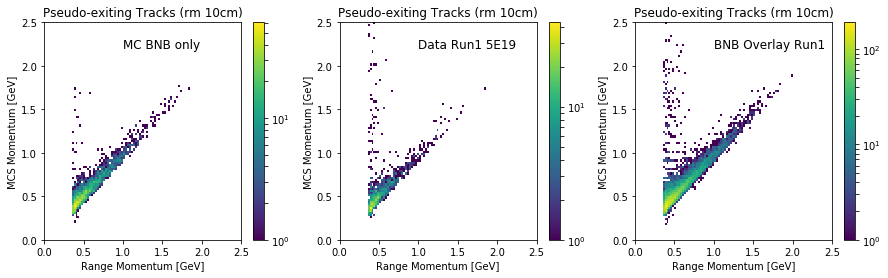

In [12]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.hist2d(rngcont_mc, mcscont_mc, bins=100, range=[[0,2.5],[0,2.5]], norm=col.LogNorm())
plt.colorbar()
plt.title(tag)
plt.xlabel('Range Momentum [GeV]')
plt.ylabel('MCS Momentum [GeV]')
plt.text(1., 2.2, label_mc, fontsize=12)
plt.subplot(132)
plt.hist2d(rngcont_data, mcscont_data, bins=100, range=[[0,2.5],[0,2.5]], norm=col.LogNorm())
plt.colorbar()
plt.title(tag)
plt.xlabel('Range Momentum [GeV]')
plt.ylabel('MCS Momentum [GeV]')
plt.text(1., 2.2, label_data, fontsize=12)
plt.subplot(133)
plt.hist2d(rngcont_ovrl, mcscont_ovrl, bins=100, range=[[0,2.5],[0,2.5]], norm=col.LogNorm())
plt.colorbar()
plt.title(tag)
plt.xlabel('Range Momentum [GeV]')
plt.ylabel('MCS Momentum [GeV]')
plt.text(1., 2.2, label_ovrl, fontsize=12)
plt.show()

Warning in <TROOT::Append>: Replacing existing TH1: biasMC BNB only (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: resolMC BNB only (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC BNB onlybin0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC BNB onlybin1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC BNB onlybin2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC BNB onlybin3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: biasData Run1 5E19 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: resolData Run1 5E19 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Data Run1 5E19bin0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Data Run1 5E19bin1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Data

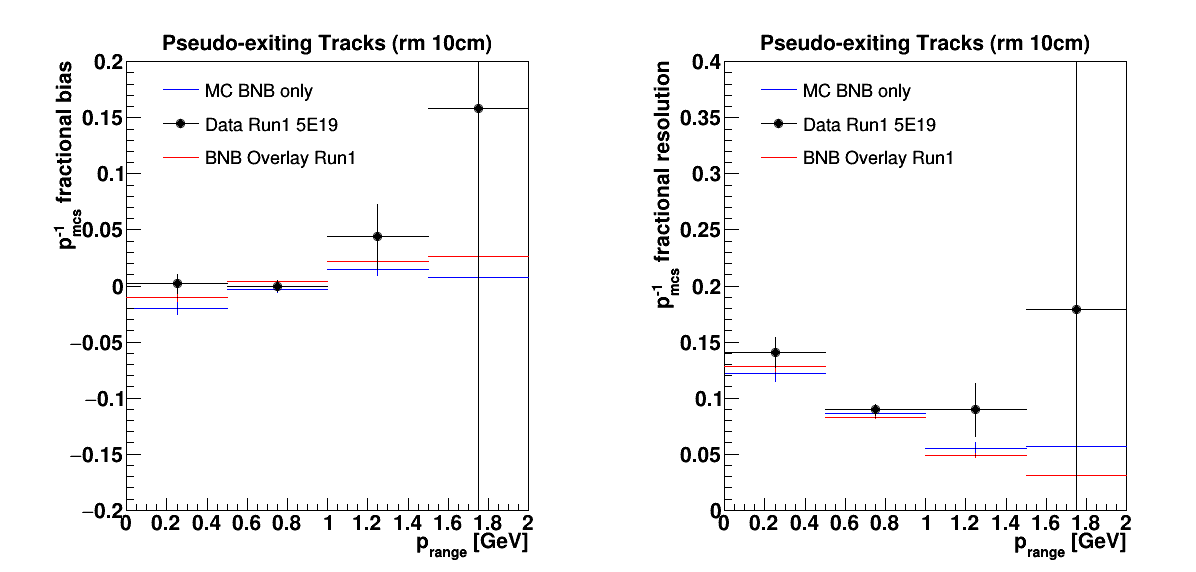

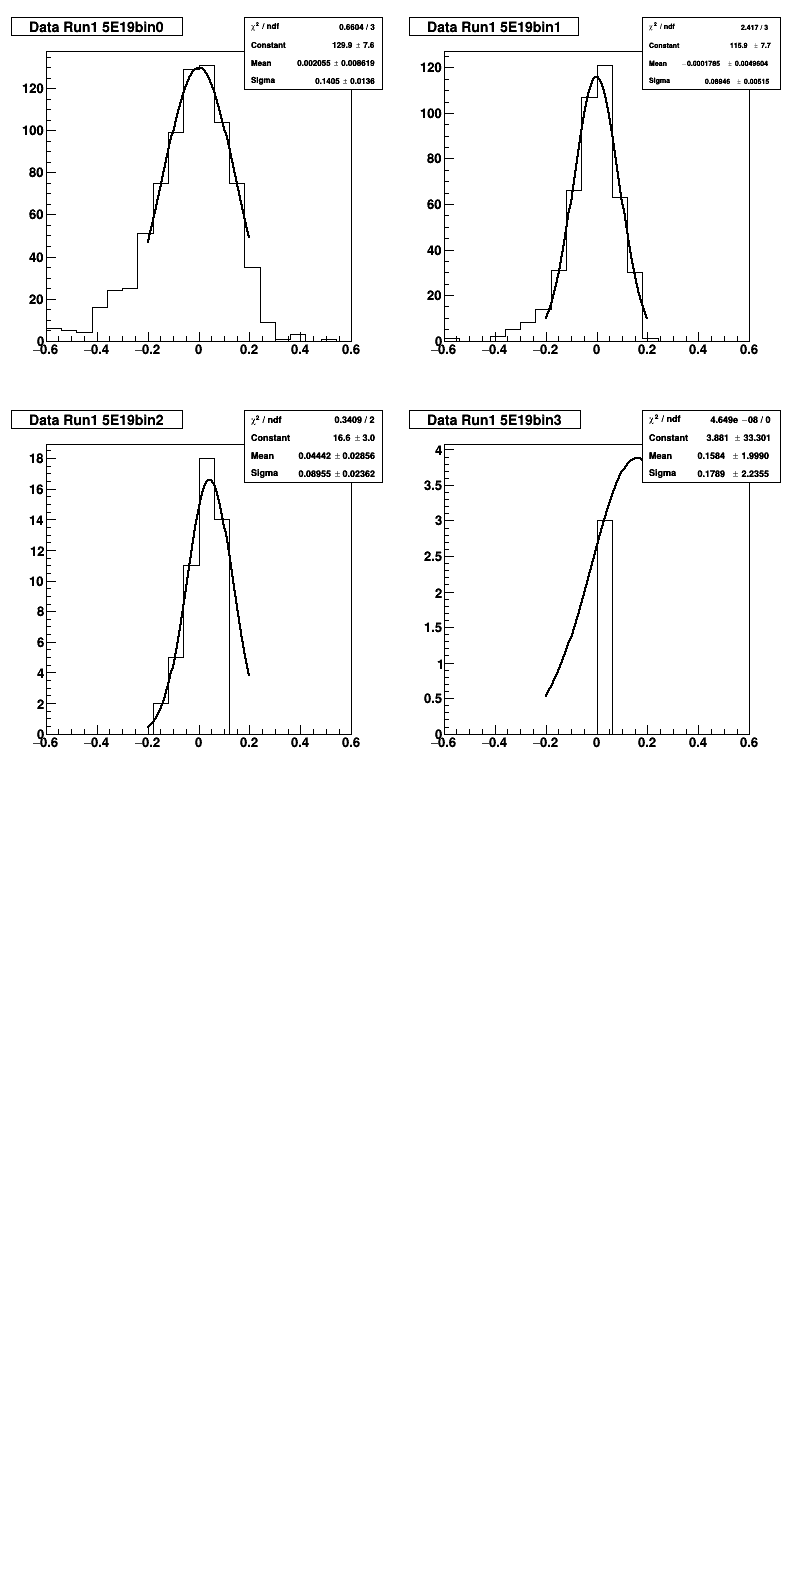

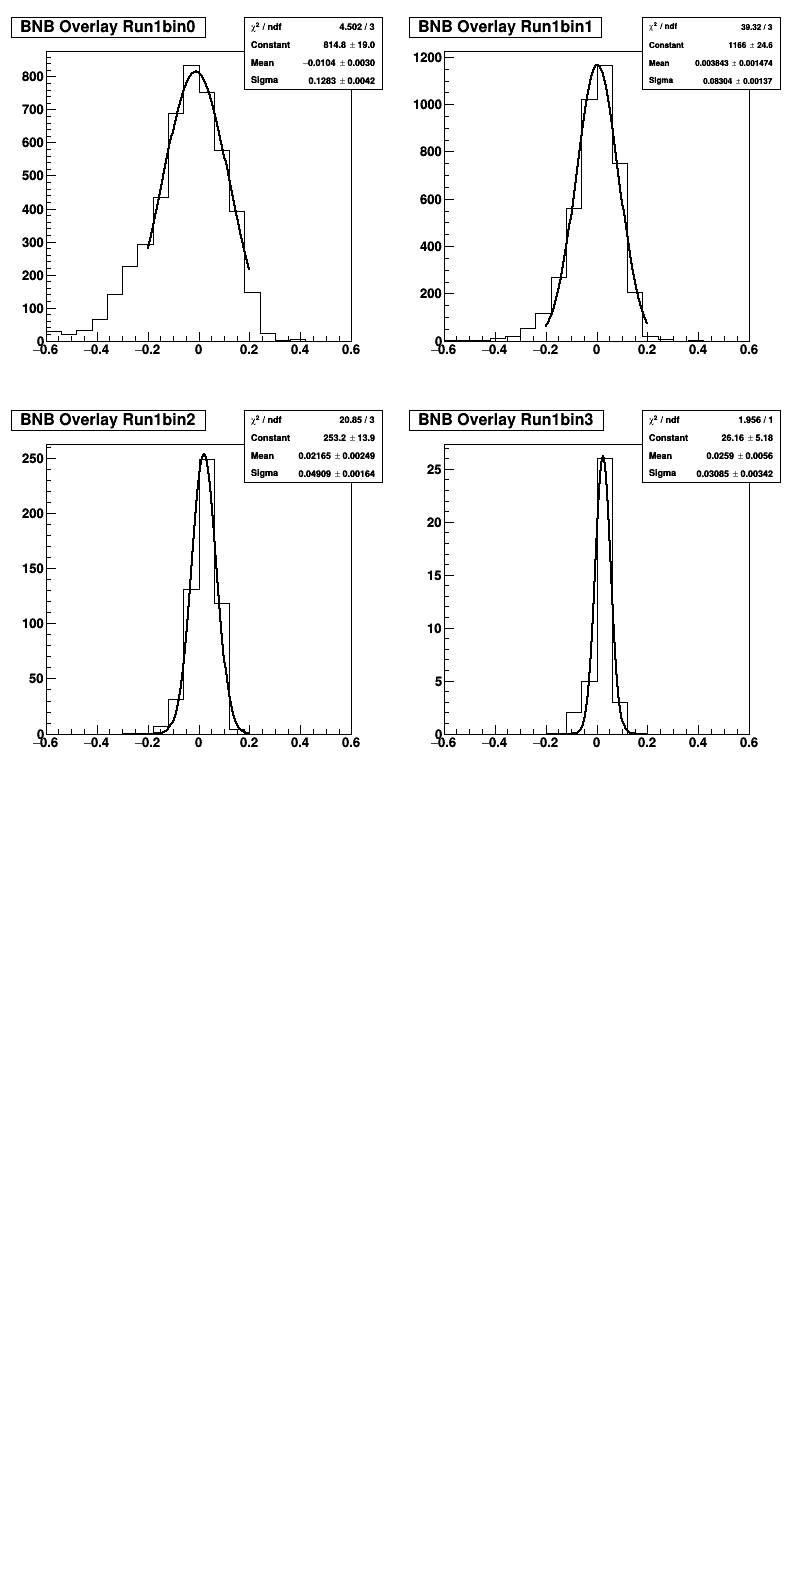

In [13]:
xmin = 0.
xmax = 2.
xstp = 0.5

hb_mc, hr_mc, hlist_mc = makeBiasAndResolPlots(selection_mc,trkMom_MuFwd_mc,trkMom_RangeMu_mc,xmin,xmax,xstp,label_mc,r.kBlue)
hb_data, hr_data, hlist_data = makeBiasAndResolPlots(selection_data,trkMom_MuFwd_data,trkMom_RangeMu_data,xmin,xmax,xstp,label_data,r.kBlack)
hb_ovrl, hr_ovrl, hlist_ovrl = makeBiasAndResolPlots(selection_ovrl,trkMom_MuFwd_ovrl,trkMom_RangeMu_ovrl,xmin,xmax,xstp,label_ovrl,r.kRed)

#hb_mc.GetYaxis().SetRangeUser(-0.1,0.3)
#hr_mc.GetYaxis().SetRangeUser(0.,0.35)
hb_mc.GetYaxis().SetRangeUser(-0.2,0.2)
hr_mc.GetYaxis().SetRangeUser(0.,0.4)

hr_data.SetMarkerStyle(20)
hb_data.SetMarkerStyle(20)

r.gStyle.SetOptStat(0)

leg = r.TLegend(.25,.70,.6,.88)
leg.SetNColumns(1)
leg.SetBorderSize(0)
leg.SetFillColor(0)
leg.SetFillStyle(0)
leg.SetTextFont(42)
leg.SetTextSize(0.035)
leg.AddEntry(hb_mc,label_mc,"L")
leg.AddEntry(hb_data,label_data,"LP")
leg.AddEntry(hb_ovrl,label_ovrl,"L")

ttext = r.TPaveText(0.20,0.90,0.9,0.96, "NDC")#NDC=relative to pad dimensions
ttext.SetFillColor(0)
ttext.SetTextSize(0.04) 
ttext.SetBorderSize(0)
ttext.AddText(tag)
ttext.Draw()

c = r.TCanvas("c","c",1200,600)
c.Divide(2,1)
c.Draw()
c.cd(1)
r.gPad.SetLeftMargin(0.2)
hb_mc.Draw()
hb_ovrl.Draw("same")
hb_data.Draw("same,P")
leg.Draw()
ttext.Draw()
c.cd(2)
r.gPad.SetLeftMargin(0.2)
hr_mc.Draw()
hr_ovrl.Draw("same")
hr_data.Draw("same,P")
ttext.Draw()
leg.Draw()

cd4 = r.TCanvas("cd4","cd4",800,1600)
cd4.Divide(2,4)
cd4.Draw()
for h in range(0,len(hlist_data)):
    cd4.cd(h+1)
    hlist_data[h].Draw()

co4 = r.TCanvas("co4","co4",800,1600)
co4.Divide(2,4)
co4.Draw()
for h in range(0,len(hlist_ovrl)):
    co4.cd(h+1)
    hlist_ovrl[h].Draw()
#print len()